In [1]:
import numpy as np
import sys
sys.path.append("../model")
from rnn_FORCE import RNN
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torch import nn
import seaborn as sns
from torch.autograd.functional import jacobian
SAVEFIG = False

In [2]:
# Initializing matrix
num_nodes = 100
np.random.seed(2)

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

# define targets
time_points = np.arange(3000)
targets = ((np.sin((time_points+1)/60*np.pi))/4 + 0.5)

In [3]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = 25
inh_weight_sum = 25
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [4]:
# define output params
# gainout= 1.15
# shiftout= -2.5
gainout= 1.3
shiftout= -0.9
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

Must use activation as x rather than state. Otherwise, the output would not be a linear readout and depend on u.

$x_{t+1} = (1-c)x_t + c * \sigma (gn * (g W x_t - s)) + c * u^*_t$, where $u^*_t = u_t + r_t$

$h(z) = \sigma (gn * (z - s)) \approx h(s) + gn * h(s) * (1-h(s)) * (z - s)$

If $s=0, gn=1$, $h(g W x_t) \approx 0.5 + 0.25 * g W x_t$

So $x_{t+1} \approx (1-c)x_t + c * (0.5 + 0.25 * g W x_t) + c * u^*_t = ((1-c)I + c * 0.25 * g W) x_t + c * u^{**}_t$

where $u^{**}_t = u_t + r_t + 0.5$



In [5]:
# imitate rnn_FORCE
class mysys():
    def __init__(self, weight_matrix, connectivity_matrix, gain, shift, input_weight_matrix=None, inputs=None):
        # core parameters
        self.weight_matrix = weight_matrix
        self.connectivity_matrix = connectivity_matrix
        self.gain = gain
        self.shift = shift
        self.inputs = inputs
        self.input_weight_matrix = input_weight_matrix
        self.activation_func = nn.Sigmoid()
        
        # transfer into tensor
        self.weight_matrix_tensor = tensor(self.weight_matrix)
        self.gain_tensor = tensor(self.gain)
        self.shift_tensor = tensor(self.shift)
        
        # constants
        self.time_const = 1
        self.timestep = 0.1
        self.c = self.timestep / self.time_const
        self.g = 1.5
        self.i = 0

    # # if u is the shift modulation    
    # def f_tensor(self, x_tensor, u_tensor, r_tensor):
    #     y_tensor = (1 - self.c) * x_tensor \
    #         + self.c * self.activation_func((self.gain_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) + r_tensor + u_tensor - self.shift_tensor))
    #     return y_tensor

    # if u and r all applied on activation    
    def f_tensor(self, x_tensor, u_tensor, r_tensor):
        y_tensor = (1 - self.c) * x_tensor \
            + self.c * self.activation_func((self.gain_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) - self.shift_tensor)) \
            + self.c * (r_tensor + u_tensor)
        return y_tensor
         
    def f(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        y_tensor = self.f_tensor(x_tensor, u_tensor, r_tensor)
        y = y_tensor.numpy()
        return y
    
    # def jacob(self, x, u, r):
    #     x_tensor = tensor(x)
    #     u_tensor = tensor(u)
    #     r_tensor = tensor(r)
    #     dydx, dydu, dydr = jacobian(self.f_tensor,(x_tensor, u_tensor, r_tensor))
    #     Jx_tensor = dydx.squeeze(dim=(1,3))
    #     Ju_tensor = dydu.squeeze(dim=(1,3))
    #     Jr_tensor = dydr.squeeze(dim=(1,3))
    #     Jx = Jx_tensor.numpy()
    #     Ju = Ju_tensor.numpy()
    #     Jr = Jr_tensor.numpy()
    #     return Jx, Ju, Jr

    def f_linear(self, x, u, r):  # assume gain == 1 and shirt == 0
        y = (1 - self.c) * x \
            + self.c * (0.5 + 0.25 * self.g * self.weight_matrix @ x) \
            + self.c * (r + u)
        return y

# jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
# jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)
jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)

### Simulate Without Control

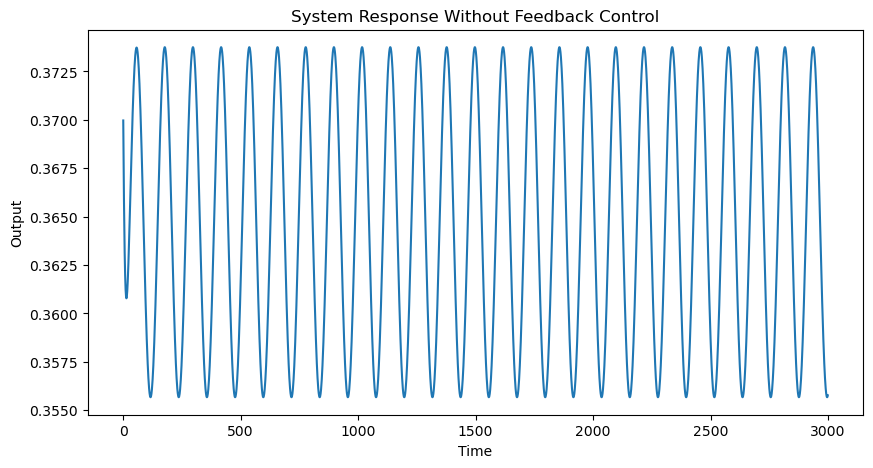

In [81]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
xs = []
outputs_ff = []

for i in time_points[:-1]:
    
    jnn_ff.i = i

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))  # previously wrong!

    # input
    this_input = targets[i]  # input t, output t+1
    r = feedback_weight_matrix @ np.array([[this_input]])
    
    # update x
    x1 = jnn_ff.f(x, u, r)
    # x1 = jnn.f_linear(x, u, r)
    # F, G, R = jnn_ff.jacob(x, u, r)
    # x1 = F @ x + G @ u + R @ r
    x = x1.copy()

    # save
    xs.append(x)
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

Text(0.5, 0, 'Time point')

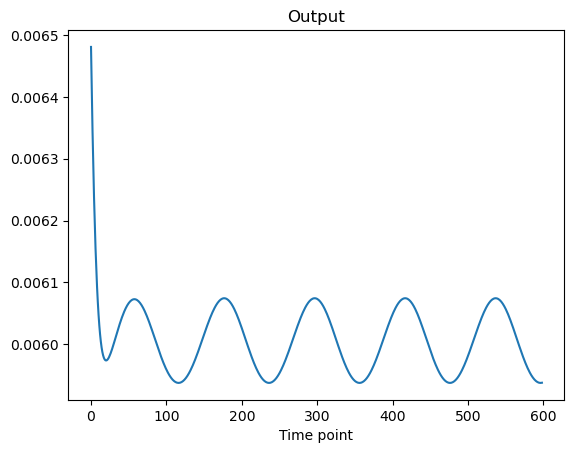

In [82]:
network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
        timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), shiftout=shiftout, gainout=gainout, target=targets)
states, activations, outputs = network.simulate(60)

plt.plot(outputs)
plt.title("Output")
plt.xlabel("Time point")

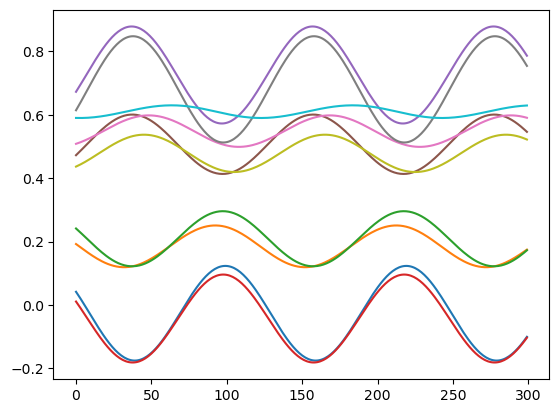

In [83]:
all_xs = np.concatenate(xs, axis=1)
for i in range(10, 20):
    plt.plot(all_xs[i,500: 800], label=f"Node {i}")

### Test Hebbian Learning Convergence

Stop here. So if we find the correct gainout and shiftout (with right scale), the hebbian learning itself (without feedback control) converges, even if the output is not clamp to the target. This is because hebbian learning always push the readout weight matrix to the right direction that individual weights are proportional to the mean activation of nodes. This does not matter if the scalar is an arbitrary output or the target.

To find the correct gainout and shiftout should not be something I worry now.

I guess there is the phase-shifting problem. Maybe feedback control can solve this? Simultaneously, the phases of different nodes are different. Maybe there is a kind of hebbian learning to align the phases with the target?

In [169]:
# define targets
time_points = np.arange(3000)
targets = ((np.sin((time_points+1)/60*np.pi))/4 + 0.5)

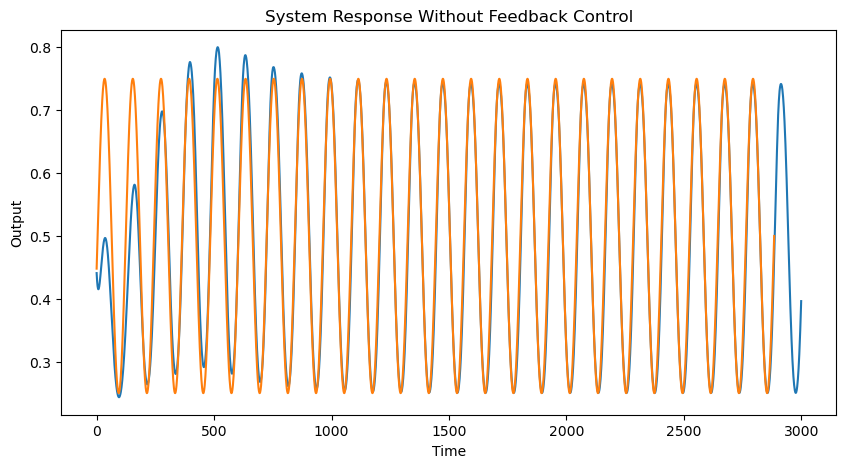

In [170]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs = []
outputs_ff = []
has_hebbian = False
# gainout= 1.48  # for f_linear
# shiftout= -0.26
gainout= 1.45  # for f
shiftout= -0.16
hebbian_lr = 0.01

for i in time_points[:-1]:
    
    jnn_ff.i = i

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    this_target = targets[i]
    if not has_hebbian and i > 100:
        has_hebbian = True
    if has_hebbian:
        # Calculate Hebbian weight updates
        # hebbian_update = this_target * x.T
        hebbian_update = output * x.T
        hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()

    # input
    this_input = targets[i]
    r = feedback_weight_matrix @ np.array([[this_input]])
    
    # update x
    # x1 = jnn_ff.f_linear(x, u, r)
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()

    # save
    xs.append(x)
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.plot(targets[115:])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

Text(0.5, 0, 'Node ID')

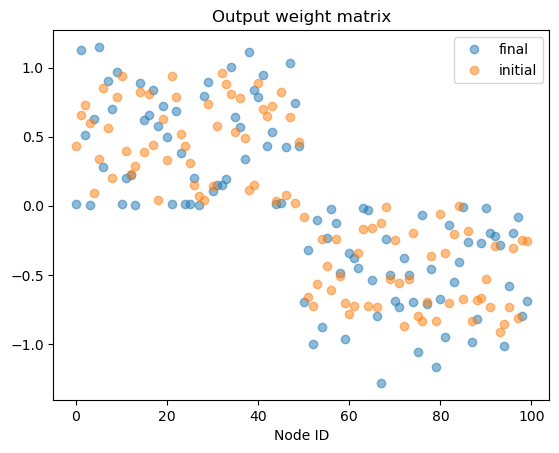

In [171]:
plt.plot(this_output_weight_matrix.flatten(), 'o', alpha=0.5, label='final')
plt.plot(output_weight_matrix.flatten(), 'o', alpha=0.5, label='initial')
plt.legend()
plt.title('Output weight matrix')
plt.xlabel('Node ID')

In [172]:
target_peak = np.argmax(targets[500:620])
np.argmax(outputs_ff[500:620]) - target_peak

6

### Hebbian Learning for Phase Correction

In [140]:
# from scipy.fft import fft, fftfreq

# def get_period_and_phase(y):

#     # Perform the Fast Fourier Transform (FFT)
#     y_mean = np.mean(y)
#     y_fft = fft(y-y_mean)

#     # Get the sample frequencies
#     sample_freq = fftfreq(time_points.size, d=time_points[1] - time_points[0])

#     # Find the index of the peak in the Fourier Transform magnitude
#     index_peak = np.argmax(np.abs(y_fft))

#     # Get the dominant frequency
#     dominant_freq = sample_freq[index_peak]

#     # Calculate the period of the signal
#     period = 1 / dominant_freq

#     # Extract the phase of the dominant frequency
#     phase_extracted = np.angle(y_fft[index_peak])

#     # print(f"Dominant Frequency: {dominant_freq} Hz")
#     # print(f"Period: {period}")
#     # print(f"Extracted Phase: {phase_extracted} radians")

#     return period, phase_extracted

# # extrach all phases in all_xs
# phases = []
# for i in range(num_nodes):
#     y = all_xs[i]
#     period, phase_extracted = get_period_and_phase(y)
#     phases.append(phase_extracted)

# phases

In [264]:
# define targets
time_points = np.arange(6000)
inputs = ((np.sin((time_points)/60*np.pi))/4 + 0.5)
targets = ((np.sin((time_points-10)/60*np.pi))/4 + 0.5)

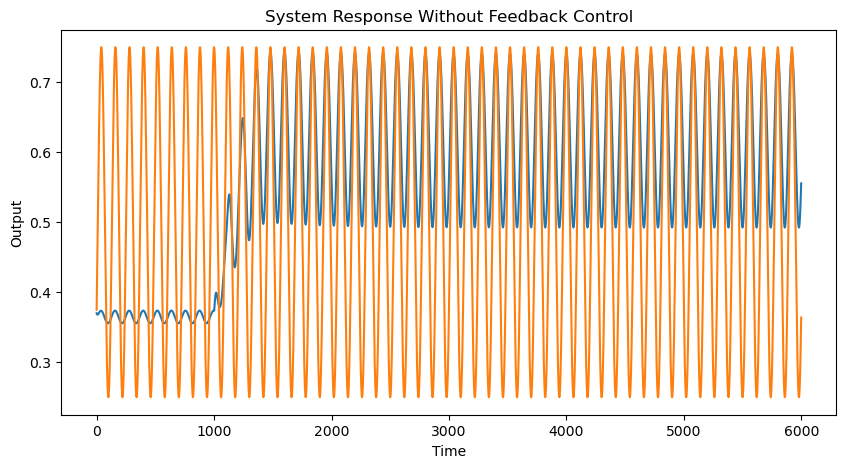

In [265]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs = []
weights = []
outputs_ff = []
has_hebbian = False
# gainout= 1.48  # for f_linear
# shiftout= -0.26
# gainout= 1.45  # for f
# shiftout= -0.16
gainout = 0.1
shiftout = 5
hebbian_lr = 0.01

for i in time_points[:-1]:
    
    jnn_ff.i = i

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    if not has_hebbian and i > 1000:
        has_hebbian = True
        x_mean = np.concatenate(xs, axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs, axis=1).std(axis=1).reshape(-1, 1)
        target_mean = 0.5
    if has_hebbian:
        this_target = targets[i]
        # Calculate Hebbian weight updates
        hebbian_update = (this_target - target_mean) * ((x - x_mean) / x_std).T
        # hebbian_update = output * x.T
        # hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()

    # input
    # this_input = targets[i]
    this_input = inputs[i]
    r = feedback_weight_matrix @ np.array([[this_input]])
    
    # update x
    # x1 = jnn_ff.f_linear(x, u, r)
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()

    # save
    xs.append(x)
    weights.append(this_output_weight_matrix.copy())
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.plot(targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

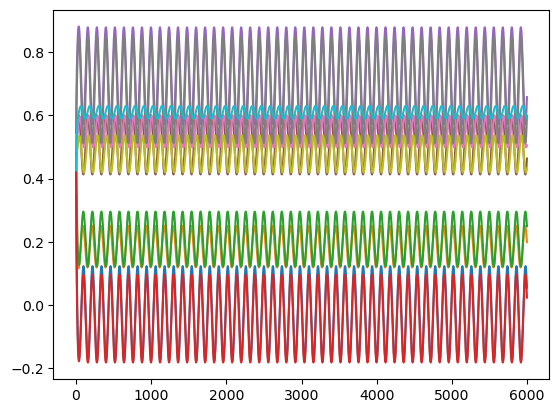

In [266]:
all_xs = np.concatenate(xs, axis=1)
for i in range(10, 20):
    plt.plot(all_xs[i,:], label=f"Node {i}")

In [267]:
peaks = []
for i in range(num_nodes):
    y = all_xs[i]
    p = np.argmax(y[500:620])
    peaks.append(p)
target_peak = np.argmax(targets[500:620])
relative_peaks = np.array(peaks) - target_peak

# plus 120 for relative peaks less than 0
relative_peaks[relative_peaks < 0] += 120
relative_peaks

array([ 60, 119, 116,  60,   2,   0,  57, 119,   2,   0,  59,  52,  57,
        58, 117, 117,   8, 118,   5,  23, 119,  58,   2,   7,  59,  58,
        57,  58,   1,   1,  58,  58,  57,  50,   0,   0, 118,  49,   1,
       118,   0, 119,  65, 119,  57,  57, 118, 119, 118,  60,   9,  57,
         0,  57, 119,  61,  59,  58,  51,   2, 113,  62,  31,  57,  58,
        65, 119,   0,  59, 112,   0,   2, 112,  53,  42,   1,  56,   3,
        55,   0, 119, 119,  57,  66,  58,  61,  88,   1, 118,  56,  57,
        60,  58,  65,   0,   3,  56,  57,   4,   1])

In [268]:
target_peak = np.argmax(targets[500:620])
np.argmax(outputs_ff[500:620]) - target_peak

-3

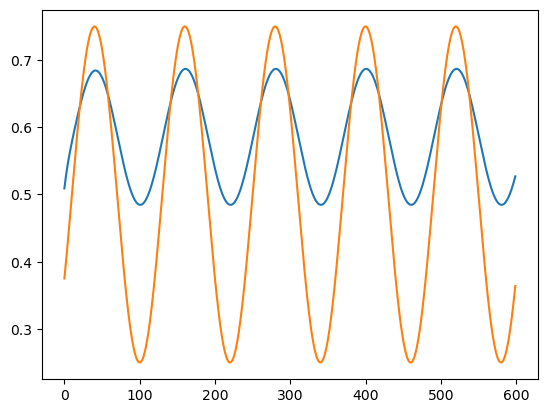

In [269]:
y = all_xs[-1]
plt.plot(y[0:600])
plt.plot(targets[0:600])

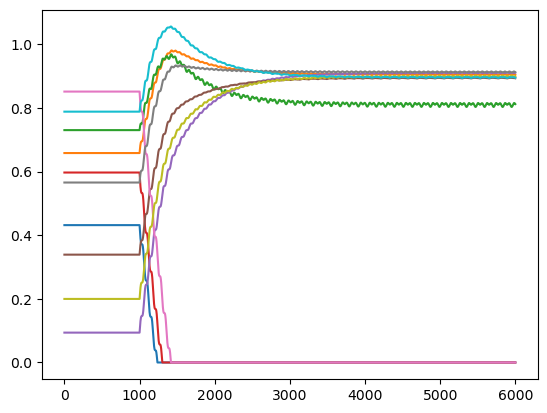

In [270]:
all_weights = np.concatenate(weights, axis=0).T
for i in range(0, 10):
    plt.plot(all_weights[i,:], label=f"Node {i}")

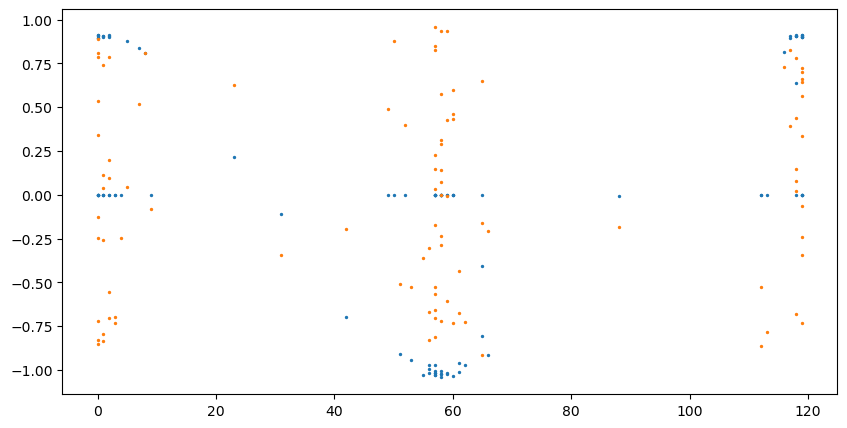

In [271]:
plt.subplots(figsize=(10, 5))
plt.scatter(relative_peaks, this_output_weight_matrix.flatten(), s=2)
plt.scatter(relative_peaks, output_weight_matrix.flatten(), s=2)

### Discrete Tracking Control

In [185]:
# calculate the desired output before the output sigmoid
def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)
y_tildes = inv_sigmoid_np(targets) / gainout + shiftout

In [222]:
# Simulate with control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
xs, us, outputs_fb_beforesig, outputs_fb = [], [], [], []
xtildes = []

# constants
R = np.eye(num_nodes) * 0.001
Q1 = np.eye(num_nodes) * 0.001
Q2 = np.eye(1) * 10
F = (1-jnn.c) * np.eye(num_nodes) + jnn.c * 0.25 * jnn.g * weight_matrix
G = jnn.c * np.eye(num_nodes)

for t in time_points[:-1]:

    jnn.i = t

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = targets[t]  # input t
    r = feedback_weight_matrix @ np.array([[this_input]])

    # linear approxmation of nonlinear system
    # linear approximate F and G and B
    # F, G, _ = jnn.jacob(x, u, r)

    # get H
    H = output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]  # target t+1
    x_tilde = L @ np.array([[y_tilde]])

    # get the control input u
    # backward solve
    S_t2 = Q
    b_t2 = np.zeros(shape=(num_nodes, 1))
    S_t1 = F.T @ (S_t2 - S_t2 @ G @ np.linalg.inv(G.T @ S_t2 @ G + R) @ G.T @ S_t2) @ F + Q
    K_T_t1 = -np.linalg.inv(G.T @ S_t2 @ G + R) @ G.T @ S_t2 @ F
    b_t1 = (F.T + K_T_t1.T @ G.T) @ b_t2 - Q @ x_tilde
    # calculate u_t
    u_star = -np.linalg.inv(G.T @ S_t1 @ G + R) @ G.T @ (S_t1 @ F @ x + b_t1)
    u = u_star - r - 0.5
    
    # update x
    # x1 = jnn.f(x, u, r)
    x1 = jnn.f_linear(x, u, r)
    x = x1.copy()
    
    # save
    xs.append(x)
    us.append(u)
    xtildes.append(x_tilde)
    outputs_fb_beforesig.append(output_beforesig.item())
    outputs_fb.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_fb_beforesig.append(output_beforesig.item())
outputs.append(output.item())

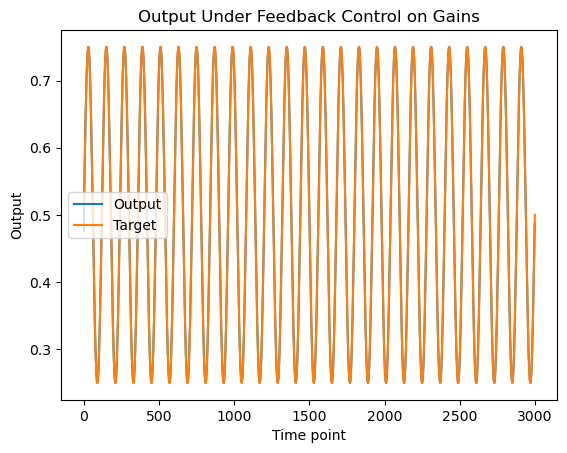

In [223]:
plt.plot(outputs_fb, label='Output')
plt.plot(targets, label='Target')
plt.title('Output Under Feedback Control on Gains')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_output.png")

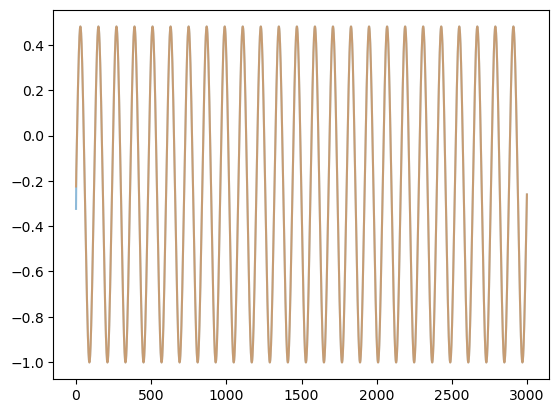

In [224]:
plt.plot(outputs_fb_beforesig, alpha=0.5)
plt.plot(y_tildes, alpha=0.5)

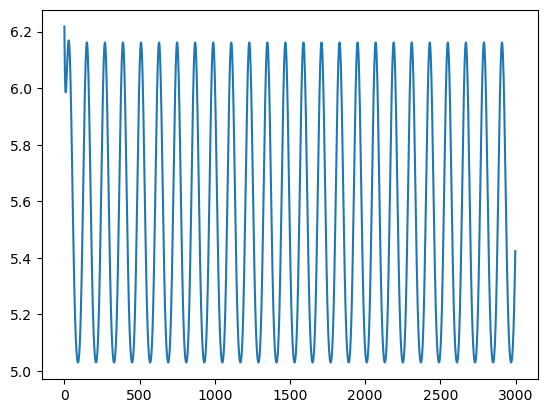

In [225]:
us_norm = [np.linalg.norm(u) for u in us]
plt.plot(us_norm)

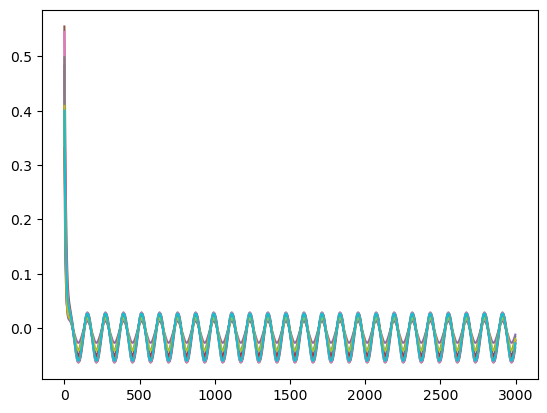

In [226]:
all_xs = np.concatenate(xs, axis=1)
for i in range(10):
    plt.plot(all_xs[i,:], label=f"Node {i}")

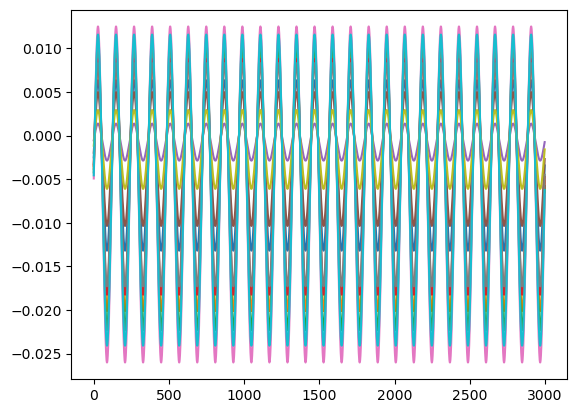

In [227]:
all_xtildes = np.concatenate(xtildes, axis=1)
for i in range(10):
    plt.plot(all_xtildes[i,:], label=f"Node {i}")

### Test Hebbian Convergence With x_tilde

In [228]:
# calculate the desired output before the output sigmoid
def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)
y_tildes = inv_sigmoid_np(targets) / gainout + shiftout

[[0.431839   0.65846483 0.73053061 0.59720841 0.09385598 0.33900884
  0.85171058 0.56578801 0.19981851 0.78859136 0.93510595 0.39567904
  0.22811931 0.28741992 0.82435712 0.38951504 0.80919164 0.43907753
  0.04400226 0.62407585 0.33311335 0.93681948 0.78403767 0.51968332
  0.42880053 0.31077578 0.14881417 0.07071384 0.03932833 0.73852371
  0.14023081 0.5751021  0.95866176 0.87971406 0.81136961 0.53664657
  0.78300181 0.48872266 0.11281388 0.14956553 0.88739552 0.70132283
  0.64907666 0.72199519 0.03379138 0.82478803 0.07714752 0.64174117
  0.02096464 0.46197831]]
[[0.431839   0.65846483 0.73053061 0.59720841 0.09385598 0.33900884
  0.85171058 0.56578801 0.19981851 0.78859136 0.93510595 0.39567904
  0.22811931 0.28741992 0.82435712 0.38951504 0.80919164 0.43907753
  0.04400226 0.62407585 0.33311335 0.93681948 0.78403767 0.51968332
  0.42880053 0.31077578 0.14881417 0.07071384 0.03932833 0.73852371
  0.14023081 0.5751021  0.95866176 0.87971406 0.81136961 0.53664657
  0.78300181 0.4887226

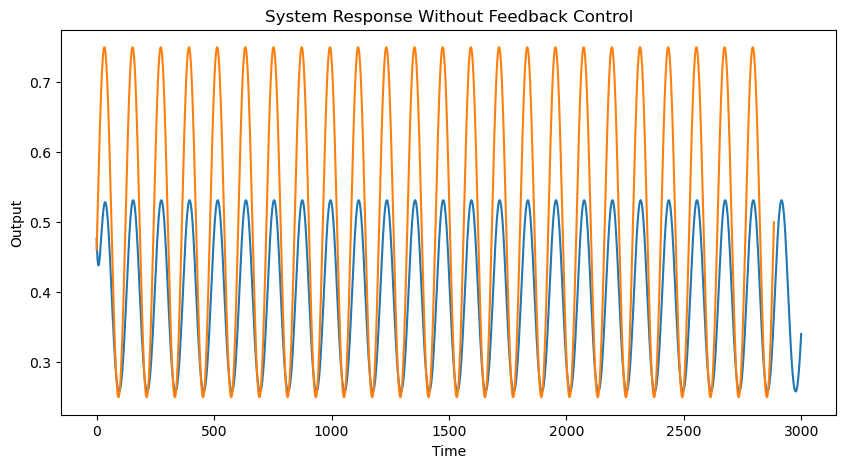

In [245]:
# Simulate with control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs = []
outputs_ff = []
has_hebbian = False
gainout= 1.48
shiftout= -0.26
hebbian_lr = 1

# constants
R = np.eye(num_nodes) * 0.001
Q1 = np.eye(num_nodes) * 0.001
Q2 = np.eye(1) * 10
F = (1-jnn.c) * np.eye(num_nodes) + jnn.c * 0.25 * jnn.g * weight_matrix
G = jnn.c * np.eye(num_nodes)

for t in time_points[:-1]:

    jnn.i = t

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    this_target = targets[t]
    if not has_hebbian and t > 100:
        has_hebbian = True
    if has_hebbian:
        # Calculate Hebbian weight updates
        # hebbian_update = output * x.T
        # hebbian_update = this_target * x.T
        hebbian_update = this_target * x_tilde.T
        hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        print(tmp_ext)
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        # print(np.linalg.norm(hebbian_lr * hebbian_update))
        # print(np.linalg.norm(tmp_output_weight_matrix - this_output_weight_matrix))
        this_output_weight_matrix = tmp_output_weight_matrix.copy()

    
    # if has_hebbian:
    #     R += np.eye(num_nodes) * 0.001
    
    # input
    this_input = targets[t]  # input t
    r = feedback_weight_matrix @ np.array([[this_input]])

    # linear approxmation of nonlinear system
    # linear approximate F and G and B
    # F, G, _ = jnn.jacob(x, u, r)

    # get H
    H = this_output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]  # target t+1
    x_tilde = L @ np.array([[y_tilde]])
    
    # update x
    x1 = jnn.f_linear(x, u, r)
    x = x1.copy()

    # save
    xs.append(x)
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.plot(targets[116:])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

Text(0.5, 0, 'Node ID')

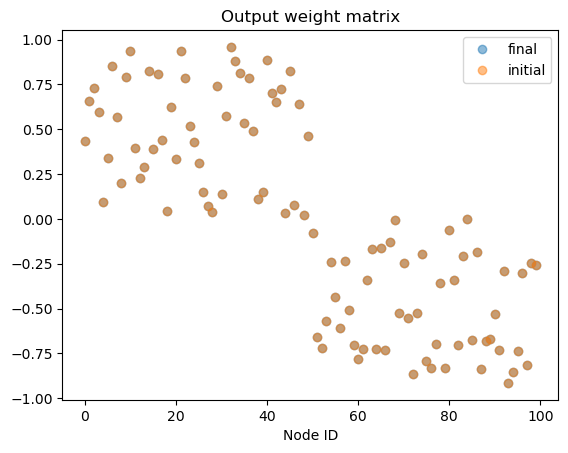

In [237]:
plt.plot(this_output_weight_matrix.flatten(), 'o', alpha=0.5, label='final')
plt.plot(output_weight_matrix.flatten(), 'o', alpha=0.5, label='initial')
plt.legend()
plt.title('Output weight matrix')
plt.xlabel('Node ID')

In [239]:
x_tilde

array([[-3.42317606e-03],
       [-5.21963292e-03],
       [-5.79089636e-03],
       [-4.73405492e-03],
       [-7.43993827e-04],
       [-2.68731394e-03],
       [-6.75148674e-03],
       [-4.48498627e-03],
       [-1.58395589e-03],
       [-6.25114239e-03],
       [-7.41255954e-03],
       [-3.13653700e-03],
       [-1.80829558e-03],
       [-2.27836994e-03],
       [-6.53465657e-03],
       [-3.08767518e-03],
       [-6.41444021e-03],
       [-3.48055568e-03],
       [-3.48804693e-04],
       [-4.94703240e-03],
       [-2.64058054e-03],
       [-7.42614267e-03],
       [-6.21504540e-03],
       [-4.11951565e-03],
       [-3.39909017e-03],
       [-2.46351116e-03],
       [-1.17964587e-03],
       [-5.60546714e-04],
       [-3.11754618e-04],
       [-5.85425744e-03],
       [-1.11160587e-03],
       [-4.55881876e-03],
       [-7.59928584e-03],
       [-6.97346952e-03],
       [-6.43170493e-03],
       [-4.25398284e-03],
       [-6.20683415e-03],
       [-3.87409131e-03],
       [-8.9

### Discrete Tracking Control Plus Hebbian Learning

In [198]:
# calculate the desired output before the output sigmoid
def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)
y_tildes = inv_sigmoid_np(targets) / gainout + shiftout

In [212]:
# Simulate with control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
this_output_weight_matrix = output_weight_matrix.copy()
xs, us, outputs_fb_beforesig, outputs_fb = [], [], [], []
u_stars = []
x_tildes = []
has_hebbian = False

# constants
R = np.eye(num_nodes) * 0.001
Q1 = np.eye(num_nodes) * 0.001
Q2 = np.eye(1) * 10
F = (1-jnn.c) * np.eye(num_nodes) + jnn.c * 0.25 * jnn.g * weight_matrix
G = jnn.c * np.eye(num_nodes)
hebbian_lr = 0.01

for t in time_points[:-1]:

    jnn.i = t

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    this_target = targets[t]
    if not has_hebbian and t > 100:
        has_hebbian = True
    if has_hebbian:
        # Calculate Hebbian weight updates
        # hebbian_update = output * x.T
        # hebbian_update = this_target * x.T
        hebbian_update = this_target * x_tilde.T
        hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()
    
    # if has_hebbian:
    #     R += np.eye(num_nodes) * 0.001
    
    # input
    this_input = targets[t]  # input t
    r = feedback_weight_matrix @ np.array([[this_input]])

    # linear approxmation of nonlinear system
    # linear approximate F and G and B
    # F, G, _ = jnn.jacob(x, u, r)

    # get H
    H = this_output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]  # target t+1
    x_tilde = L @ np.array([[y_tilde]])

    # get the control input u
    # backward solve
    S_t2 = Q
    b_t2 = np.zeros(shape=(num_nodes, 1))
    S_t1 = F.T @ (S_t2 - S_t2 @ G @ np.linalg.inv(G.T @ S_t2 @ G + R) @ G.T @ S_t2) @ F + Q
    K_T_t1 = -np.linalg.inv(G.T @ S_t2 @ G + R) @ G.T @ S_t2 @ F
    b_t1 = (F.T + K_T_t1.T @ G.T) @ b_t2 - Q @ x_tilde
    # calculate u_t
    u_star = -np.linalg.inv(G.T @ S_t1 @ G + R) @ G.T @ (S_t1 @ F @ x + b_t1)
    u = u_star - r - 0.5
    # u *= 0
    
    # update x
    x1 = jnn.f_linear(x, u, r)
    x = x1.copy()

    # save
    xs.append(x)
    us.append(u)
    u_stars.append(u_star)
    x_tildes.append(x_tilde)
    outputs_fb_beforesig.append(output_beforesig.item())
    outputs_fb.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_fb_beforesig.append(output_beforesig.item())
outputs.append(output.item())

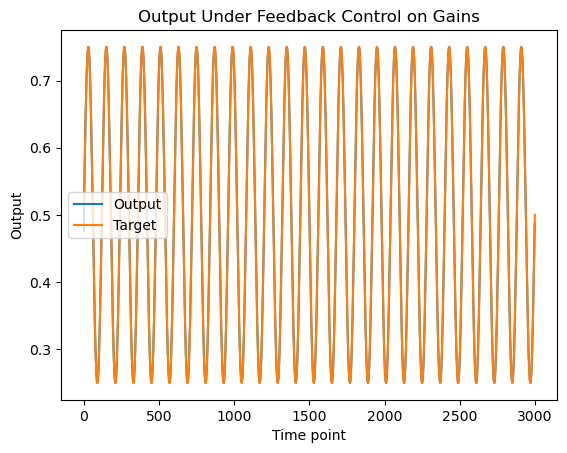

In [213]:
plt.plot(outputs_fb, label='Output')
plt.plot(targets, label='Target')
plt.title('Output Under Feedback Control on Gains')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_output.png")

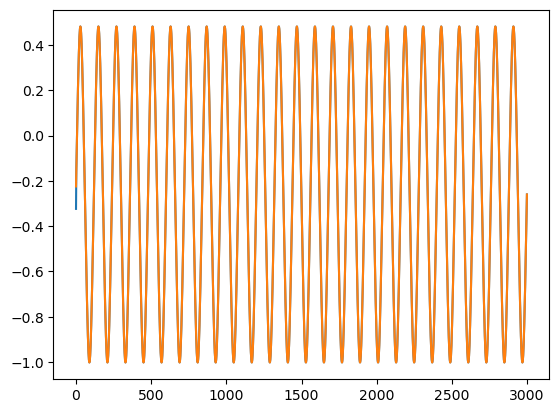

In [214]:
plt.plot(outputs_fb_beforesig)
plt.plot(y_tildes)

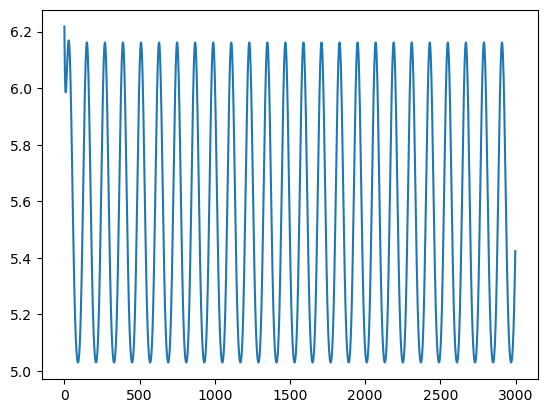

In [215]:
us_norm = [np.linalg.norm(u) for u in us]
plt.plot(us_norm)

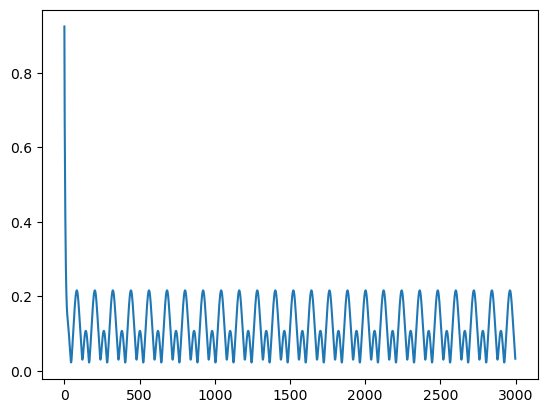

In [216]:
ustars_norm = [np.linalg.norm(u) for u in u_stars]
plt.plot(ustars_norm)

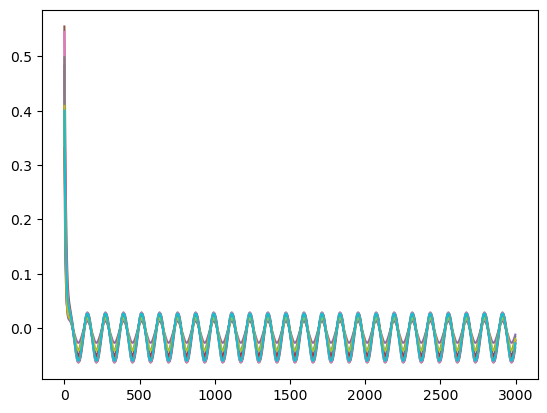

In [217]:
all_xs = np.concatenate(xs, axis=1)
for i in range(10):
    plt.plot(all_xs[i,:], label=f"Node {i}")

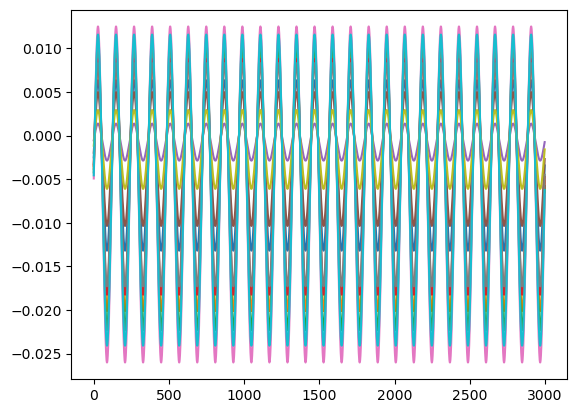

In [218]:
all_xtildes = np.concatenate(x_tildes, axis=1)
for i in range(10):
    plt.plot(all_xtildes[i,:], label=f"Node {i}")

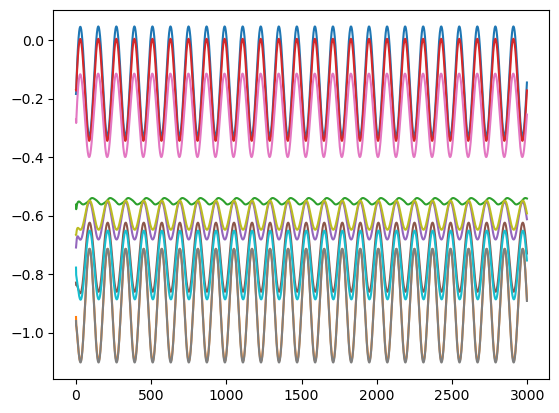

In [219]:
all_us = np.concatenate(us, axis=1)
for i in range(10):
    plt.plot(all_us[i, :])

Text(0.5, 0, 'Node ID')

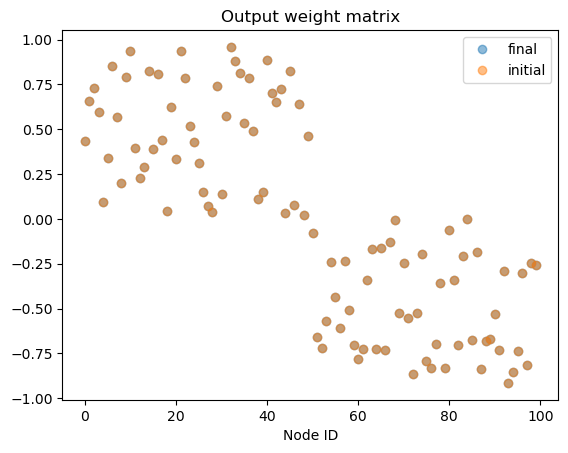

In [220]:
plt.plot(this_output_weight_matrix.flatten(), 'o', alpha=0.5, label='final')
plt.plot(output_weight_matrix.flatten(), 'o', alpha=0.5, label='initial')
plt.legend()
plt.title('Output weight matrix')
plt.xlabel('Node ID')

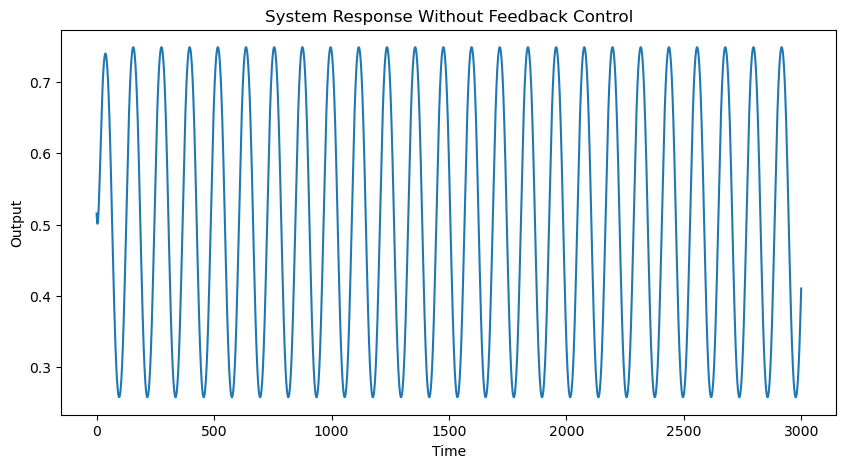

In [208]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
xs = []
outputs_ff = []

for i in time_points[:-1]:
    
    jnn_ff.i = i

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))  # previously wrong!

    # input
    this_input = targets[i]  # input t, output t+1
    r = feedback_weight_matrix @ np.array([[this_input]])
    
    # update x
    # x1 = jnn_ff.f(x, u, r)
    x1 = jnn.f_linear(x, u, r)
    # F, G, R = jnn_ff.jacob(x, u, r)
    # x1 = F @ x + G @ u + R @ r
    x = x1.copy()

    # save
    xs.append(x)
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()